In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import scipy
import arviz as az
import pymc3 as pm
from tqdm import tqdm
import theano
import theano.tensor as tt
import pandas as pd
import datetime

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
from tools import *
from existing import Regeneration_Model
from model import Convolution
from utils import DataReader

In [3]:
theano.config.floatX= 'float64'
az.style.use("arviz-darkgrid")

In [4]:
us06_covid19_csv = "dataset/US06_COVID19.csv"
us06_covid19_df = pd.read_csv(us06_covid19_csv)
us06_policy_csv = "dataset/US06_Policy.csv"
us06_policy_df = pd.read_csv(us06_policy_csv)

In [5]:
ID = "US06"
d = DataReader(ID, us06_covid19_df, us06_policy_df)
d.start_date = datetime.date(2020, 3, 9)
d.end_date = datetime.date(2020, 5, 5)
fit_start_date = datetime.datetime.strptime(d.start_date, "%Y-%m-%d").date()
fit_end_date = datetime.date(2020, 4, 24)
fit_ndays = (fit_end_date - fit_start_date).days + 1

In [6]:
Id_covid19_series = d.confirmed_cases_new
Rd_covid19_series = d.recovered_cases_new
Dd_covid19_series = d.deaths_cases_new
policy_series = d.policy_series

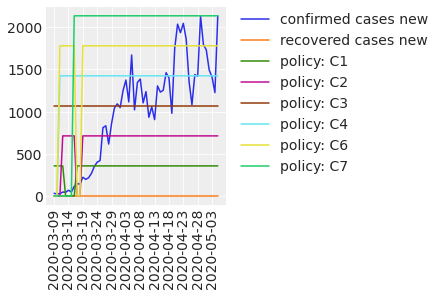

In [7]:
d.plot()

In [8]:
policy_series = []
change_point1 = (datetime.date(2020, 3, 11) - datetime.datetime.strptime(d.start_date, "%Y-%m-%d").date()).days + 1
change_point2 = (datetime.date(2020, 3, 12) - datetime.datetime.strptime(d.start_date, "%Y-%m-%d").date()).days + 1
change_point3 = (datetime.date(2020, 3, 16) - datetime.datetime.strptime(d.start_date, "%Y-%m-%d").date()).days + 1
change_point4 = (datetime.date(2020, 3, 19) - datetime.datetime.strptime(d.start_date, "%Y-%m-%d").date()).days + 1
for i in range(change_point1):
    policy_series.append([0, 0, 0, 0])
    pass
for i in range(change_point2-change_point1):
    policy_series.append([1, 0, 0, 0])
    pass
for i in range(change_point3-change_point2):
    policy_series.append([0, 1, 0, 0])
    pass
for i in range(change_point4-change_point3):
    policy_series.append([0, 0, 1, 0])
    pass
for i in range((len(d.dates)-change_point4)):
    policy_series.append([0, 0, 0, 1])
    pass
print(np.array(policy_series).shape)

(58, 4)


In [9]:
with pm.Model() as model:
    
    n_steps = len(d.dates)
    
    N = 3894.02e4
    
    PositiveNormal = pm.Bound(pm.Normal, lower=0.0)
    
    # layer 0
    N0 = pm.HalfCauchy(r'$N_{\alpha_{0}}$', beta=100)
    i0 = tt.constant(np.array(1, dtype=np.float64))
    S0t = N0 - i0
    
    lambda0 = PositiveNormal(r'$\lambda_{\alpha_{0}}$', mu=0.09, sigma=0.05)
    t = tt.constant(np.float64([i for i in range(n_steps)]))
    G0t = lambda0 * np.exp(1) ** -(lambda0 * t)
    G0t = G0t / tt.sum(G0t)
    
    R0 = PositiveNormal(r"$R_{0,\alpha_{0}}$", mu=2.7, sigma=0.1)
    
    i0t_history = tt.concatenate([tt.reshape(i0, newshape=(1,)), \
                                  tt.constant(np.zeros((n_steps-1,), dtype=np.float64))], axis=0)
    
    policy_weights_0 = tt.constant(np.zeros(np.array(policy_series).shape[-1], dtype=np.float64))
    
    _1, _2, i0t, I0t, I0tc, R0t = \
    Regeneration_Model(R0, G0t, S0t, i0t_history, N0, policy_series, policy_weights_0)
    i0t_ = pm.Deterministic(r'$i_{\alpha_{0},0}(t)$', i0t)
    
    # layer 1
    N1 = N / N0
    k1 = PositiveNormal(r"$k_{s,\alpha_{1}}$", mu=0.055, sigma=0.005)
    
    G1t = I0t
    
    i1 = pm.HalfCauchy(name=r"$i_{0s,\alpha_{1}}$", beta=100)
    S1t = N1 - i1
    
    i1t_history = tt.concatenate([tt.reshape(i1, newshape=(1,)), \
                                  tt.constant(np.zeros((n_steps-1,), dtype=np.float64))], axis=0)
    

    change_k1_1 = pm.Uniform(r"Change in $k_{s,\alpha_{1}}$ on March 11, 2020", \
                             lower=0, upper=k1)
    change_k1_1 = tt.reshape(change_k1_1, newshape=(1,))
    change_k1_2 = pm.Uniform(r"Change in $k_{s,\alpha_{1}}$ on March 12, 2020", \
                             lower=change_k1_1[0], upper=k1)
    change_k1_2 = tt.reshape(change_k1_2, newshape=(1,))
    change_k1_3 = pm.Uniform(r"Change in $k_{s,\alpha_{1}}$ on March 16, 2020", \
                             lower=0, upper=k1)
    change_k1_3 = tt.reshape(change_k1_3, newshape=(1,))
    change_k1_4 = pm.Uniform(r"Change in $k_{s,\alpha_{1}}$ on March 19, 2020", \
                             lower=change_k1_2[0], upper=k1)
    change_k1_4 = tt.reshape(change_k1_4, newshape=(1,))
    policy_weights_1 = tt.concatenate([change_k1_1, change_k1_2, change_k1_3, change_k1_4], axis=0)
    
    _1, _2, i1t, I1t, I1tc, k1t = \
    Regeneration_Model(k1, G1t, S1t, i1t_history, N1, policy_series, policy_weights_1)
    i1t_ = pm.Deterministic(r'$i_{s,\alpha_{1},0}(t)$', i1t)
    k1t_ = pm.Deterministic(r'$k_{s,\alpha_{1}}(t)$', k1t)
    
    it = Convolution(i0t, i1t)
    it = pm.Deterministic(r'$i(t)$', it[0:n_steps])
    
    eps = pm.HalfNormal(r'$\varepsilon_{i(t)}$')
    obs_fit = pm.Normal(r'Fit', mu=it[:fit_ndays], sigma=eps*it[:fit_ndays], shape=(len(Id_covid19_series[:fit_ndays])), \
                        observed=Id_covid19_series[:fit_ndays])  
    obs_forecast = pm.Deterministic(r'Forecast', it[fit_ndays:])
    
    step1 = pm.Metropolis(vars=[it])
    step2 = pm.Slice(vars=[eps])
    trace = pm.sample(4000, cores=4, chains=4, tune=6000, step=[step1, step2], init='advi', \
                      return_inferencedata=True)
    pass    

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [$N_{\alpha_{0}}$]
>>Metropolis: [$R_{0,\alpha_{0}}$]
>>Metropolis: [$\lambda_{\alpha_{0}}$]
>>Metropolis: [$i_{0s,\alpha_{1}}$]
>>Metropolis: [Change in $k_{s,\alpha_{1}}$ on March 11, 2020]
>>Metropolis: [$k_{s,\alpha_{1}}$]
>>Metropolis: [Change in $k_{s,\alpha_{1}}$ on March 12, 2020]
>>Metropolis: [Change in $k_{s,\alpha_{1}}$ on March 16, 2020]
>>Metropolis: [Change in $k_{s,\alpha_{1}}$ on March 19, 2020]
>Slice: [$\varepsilon_{i(t)}$]


Sampling 4 chains for 6_000 tune and 4_000 draw iterations (24_000 + 16_000 draws total) took 340 seconds.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


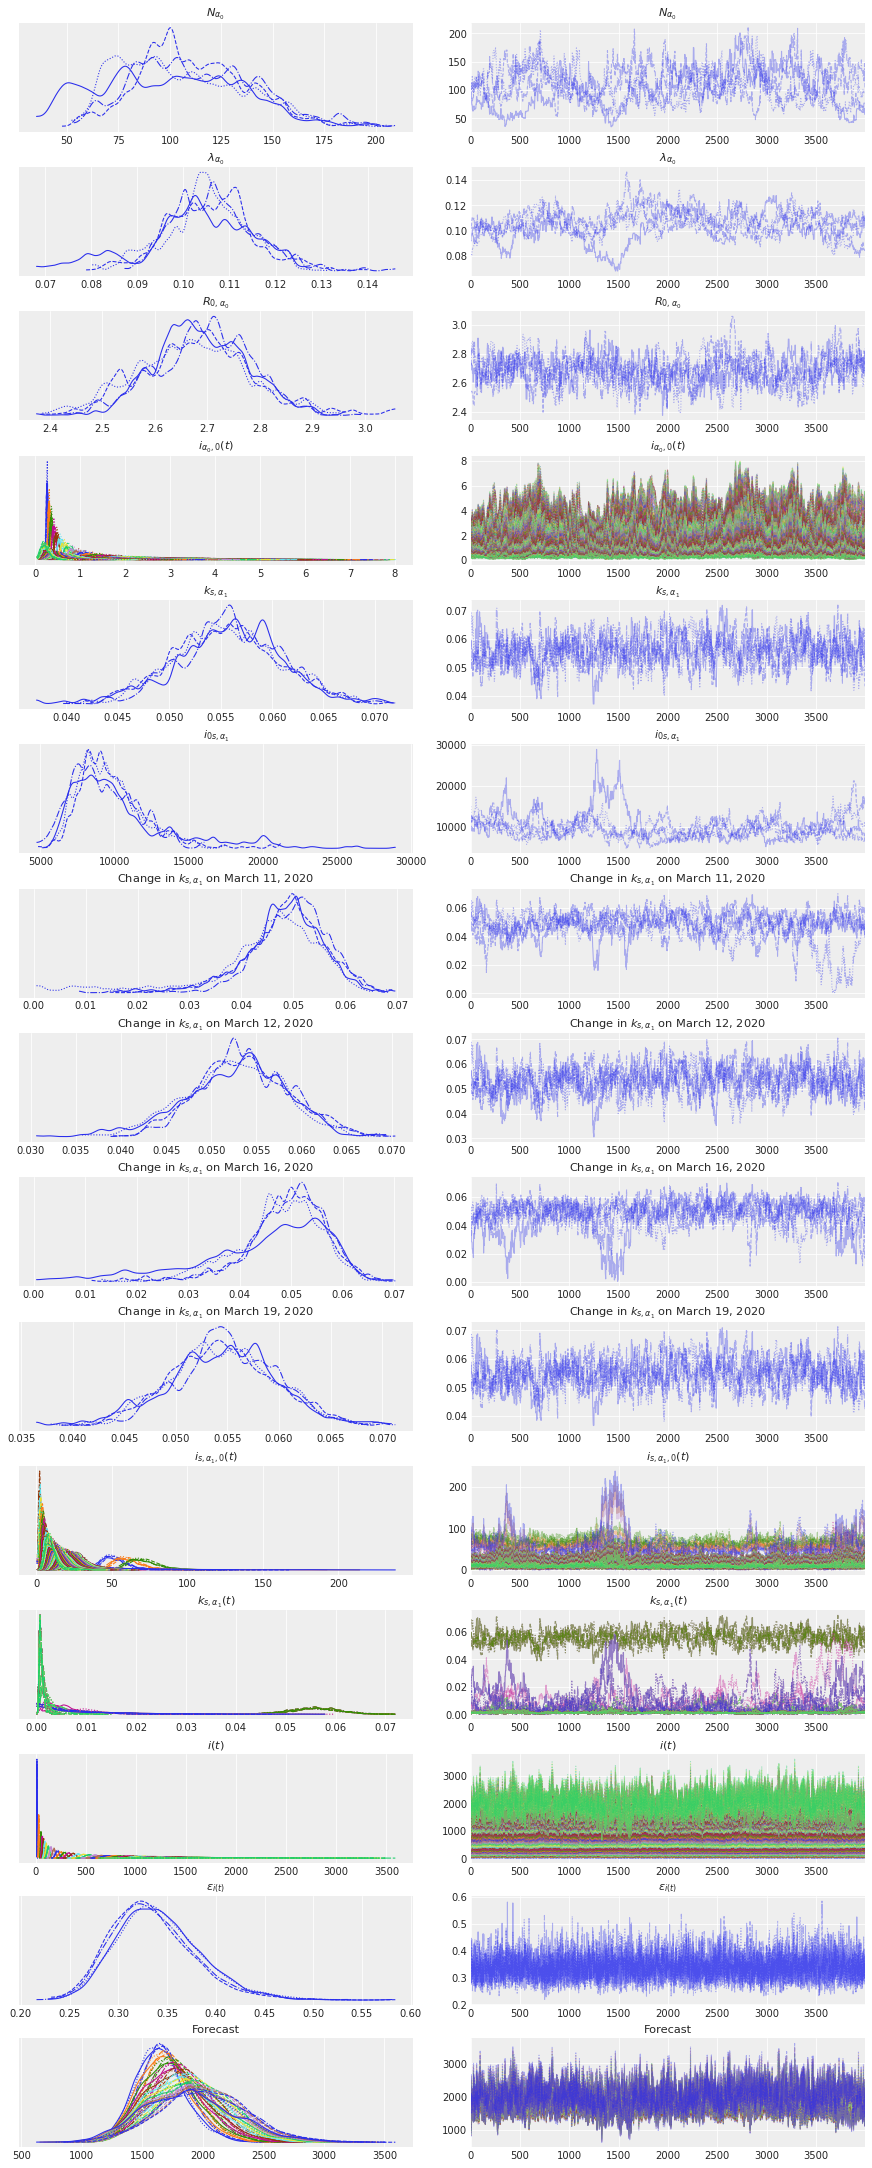

In [10]:
az.plot_trace(trace)
plt.show()

In [11]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
$N_{\alpha_{0}}$,107.471,30.567,49.888,160.327,4.166,2.962,48.0,86.0,1.09
$\lambda_{\alpha_{0}}$,0.105,0.010,0.086,0.126,0.001,0.001,62.0,59.0,1.07
"$R_{0,\alpha_{0}}$",2.683,0.099,2.495,2.862,0.008,0.006,163.0,315.0,1.02
"$i_{\alpha_{0},0}(t)$[0]",0.265,0.021,0.226,0.307,0.003,0.002,61.0,72.0,1.08
"$i_{\alpha_{0},0}(t)$[1]",0.309,0.028,0.255,0.363,0.004,0.003,61.0,73.0,1.08
...,...,...,...,...,...,...,...,...,...
Forecast[6],1884.093,313.508,1284.879,2454.543,24.622,17.442,153.0,835.0,1.03
Forecast[7],1909.094,330.841,1268.985,2505.094,28.286,20.044,133.0,653.0,1.03
Forecast[8],1929.710,347.713,1236.627,2538.663,30.470,21.594,130.0,598.0,1.03
Forecast[9],1945.599,364.011,1237.889,2602.242,32.081,22.736,129.0,578.0,1.03


In [12]:
with model:
    pp = pm.sample_posterior_predictive(trace, samples=1000, \
                                        var_names=["Fit", "Forecast", \
                                                   r'$\varepsilon_{i(t)}$', r"$k_{s,\alpha_{1}}(t)$"])
    pp_fit = pp["Fit"]
    dtm_forecast = pp["Forecast"]
    pp_eps = pp[r'$\varepsilon_{i(t)}$']
    pp_k1t = pp[r"$k_{s,\alpha_{1}}(t)$"]
    pass

E:\anaconda3\envs\covid19bayes\lib\site-packages\pymc3\sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


In [13]:
pp_forecast = pm.Normal.dist(mu=dtm_forecast, sigma=dtm_forecast*pp_eps.reshape((pp_eps.shape[0], 1))).random()

E:\anaconda3\envs\covid19bayes\lib\site-packages\arviz\plots\hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


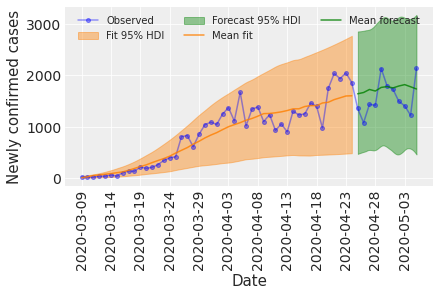

In [14]:
fig, ax = plt.subplots()
fig.patch.set_facecolor('white')
    
ax.plot(np.arange(len(Id_covid19_series)), Id_covid19_series, "o-", ms=4, \
        color="blue", alpha=0.4, label="Observed")
az.plot_hdi(np.arange(fit_ndays), pp_fit, hdi_prob=0.95, \
            color="#FF7F00", fill_kwargs={"alpha": 0.4, "label": "Fit 95% HDI"})
az.plot_hdi(np.arange(fit_ndays, len(Id_covid19_series)), pp_forecast, hdi_prob=0.95, \
            color="green", fill_kwargs={"alpha": 0.4, "label": "Forecast 95% HDI"})
ax.plot(np.arange(fit_ndays), pp_fit.mean(0), color="#FF7F00", alpha=0.8, label="Mean fit")
ax.plot(np.arange(fit_ndays, len(Id_covid19_series)), pp_forecast.mean(0), color="green", \
        alpha=0.8, label="Mean forecast")

x_day_interval = max(1, (len(d.dates)) // 10)
plt.xticks(list(range(0, len(d.dates), x_day_interval)), d.dates[0::x_day_interval], rotation="vertical")
plt.xlabel("Date")
plt.ylabel("Newly confirmed cases")
ax.legend(ncol=3, fontsize=10, loc="upper center")

plt.savefig(r"outputs\{}_A.png".format(ID), dpi=600, format="png")
plt.show()

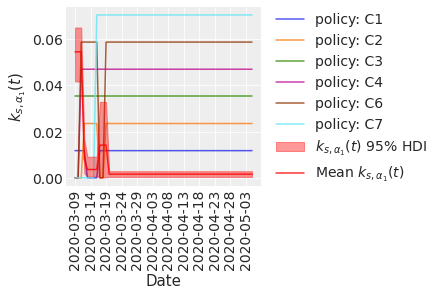

In [15]:
fig, ax = plt.subplots()
fig.patch.set_facecolor('white')

rmax = np.max(np.array(pp_k1t))
rmin = np.min(np.array(pp_k1t))
n_policy_valid = np.sum((np.sum(np.array(d.policy_series), axis=0)>0).astype(int))
j = 0
for i, p in enumerate(d._DataReader__policy_reader.PolicyType):
    if np.sum(np.array(d.policy_series)[:, i]) > 0:
        j += 1
        plt.plot((rmax-rmin)*np.array(d.policy_series)[:, i]*j/(1.0*n_policy_valid)+rmin, \
                 alpha=0.8, label="policy: "+p, zorder=0.8)
        pass
    pass
az.plot_hdi(np.arange(len(Id_covid19_series)), pp_k1t, hdi_prob=0.95, smooth=False, \
                  color="red", fill_kwargs={"alpha": 0.4, "label": r"$k_{s,\alpha_{1}}(t)$ 95% HDI"})
ax.plot(np.arange(len(Id_covid19_series)), pp_k1t.mean(0), color="red", \
        alpha=0.8, label=r"Mean $k_{s,\alpha_{1}}(t)$")
x_day_interval = max(1, (len(d.dates)) // 10)
plt.xticks(list(range(0, len(d.dates), x_day_interval)), d.dates[0::x_day_interval], rotation="vertical")
plt.xlabel("Date")
plt.ylabel(r"$k_{s,\alpha_{1}}(t)$")
plt.legend(bbox_to_anchor=(1.05, 1.0), borderaxespad=0)

plt.savefig(r"outputs\{}_B.png".format(ID), dpi=600, format="png")
plt.show()